In [1]:
versioninfo()

Julia Version 1.9.0
Commit 8e630552924 (2023-05-07 11:25 UTC)
Platform Info:
  OS: Linux (x86_64-linux-gnu)
  CPU: 16 × AMD Ryzen 7 PRO 4750U with Radeon Graphics
  WORD_SIZE: 64
  LIBM: libopenlibm
  LLVM: libLLVM-14.0.6 (ORCJIT, znver2)
  Threads: 2 on 16 virtual cores
Environment:
  JULIA_PKG_SERVER = https://mirrors.tuna.tsinghua.edu.cn/julia


# 0 Turing.jl

- https://turinglang.org/
- https://github.com/TuringLang/Turing.jl


In [5]:
# Import all libraries.
using Turing, StatsPlots, Random

In [32]:
using Fmt
print(Fmt.format(f"{1} {2}", "foo", "haha") )
println(Fmt.format(f"{1} {2}", "foo", "bar") )
println(Fmt.format(f"{x} {y}", x = "foo", y = "bar") )

foo hahafoo bar
foo bar


In [33]:
x = 42
print(f"x is {$data}.")
display(f"x is {$data}.")


x is Bool[1, 0, 0, 0, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 1, 1, 0, 0, 0, 1, 0, 1, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 1, 0, 1, 1, 1, 0, 1, 1, 0, 1, 1, 0, 0, 0, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1].

"x is Bool[1, 0, 0, 0, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 1, 1, 0, 0, 0, 1, 0, 1, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 1, 0, 1, 1, 1, 0, 1, 1, 0, 1, 1, 0, 0, 0, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1]."

# 1 The Problem: Coin flipping

Flip a coin. A random variable x = 1 if the coin is head up. x=0 if the coin is tail up.

## 1.1 Question
- Input: a sequence of observed x.
- Output: what is the p(head up) of the coin?

## 1.2 Input: flip 100 times

The number of ups is 43/100.


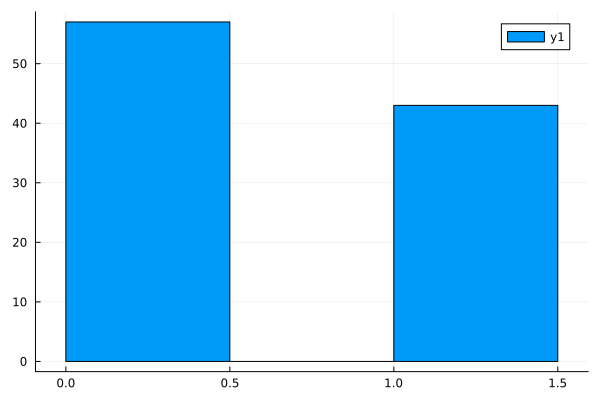

In [57]:
# Set the true probability of heads in a coin.
p_true = 0.5

# Iterate from having seen 0 observations to 100 observations.
Ns = 0:100

# Fix the seed and draw data from a Bernoulli distribution, i.e. draw heads or tails.
Random.seed!(12)
data = rand(Bernoulli(p_true), last(Ns))

println(Fmt.format(f"The number of ups is {1}/{2}.", sum(data), length(data)) ); 
histogram(data)

# 2 Likelihood approach

p is an unknown parameter to be solved.


$$ x_i \sim Bernoulli(p)$$


The MLE (maximum likelihood estimator) is $\hat p=\frac{\sum_{i=1}^{i=N} x_i }{N}$ and why?

- What is the difference between likelihood and probability? What is MLE?
- Why most estimators we know/use are MLE estimators?
- Analytic/closed-form （解析） solution vs Monte Carlo solution vs Brute force solution?
  - https://en.wikipedia.org/wiki/Closed-form_expression

For any model (Likelihood or Bayesian):
- Is there an analytic solution? No for most real-world problems.
- Is there a monte carlo solution? Yes for most real-world problems.
- Is there a brute-force solution? Yes. But may take hundreds of years.


## 2.1 The MLE (maximum likelihood estimator) is  $\hat p=\frac{\sum_{i=1}^{i=N} x_i }{N}$ and why?


- https://stats.stackexchange.com/questions/275380/maximum-likelihood-estimation-for-bernoulli-distribution

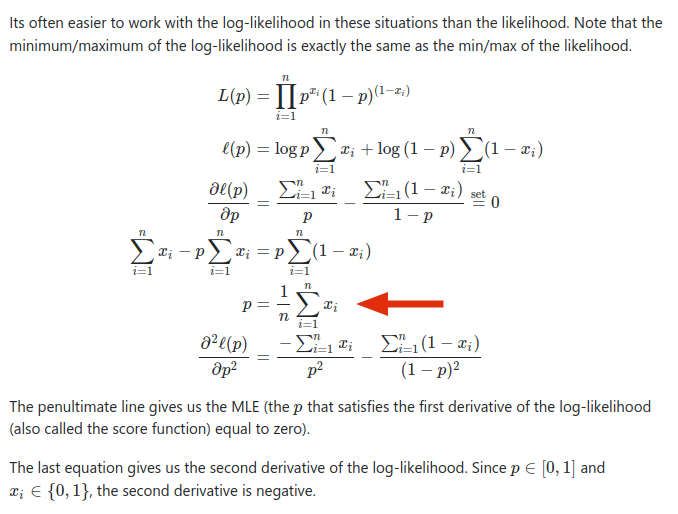

# 3 Bayesian

p is a random variable with a prior distribution.

$$ p \sim Beta(\alpha, \beta)$$
$$ x_i \sim Bernoulli(p)$$

Note: x is Bernoulli, 0 or 1, not Binomial.

Question: derive the posterior distribution of $p$, AKA (Also Known As), $Prob(p|x_1, ... x_N)$.

- Is there an analytic solution to this? Yes, Beta-Binomial.

  - https://en.wikipedia.org/wiki/Beta-binomial_distribution
  
  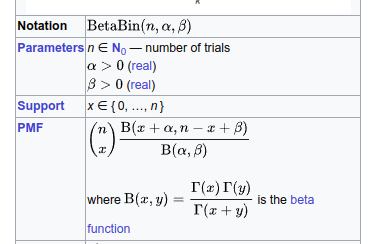

- Is there a monte carlo solution? Yes, we will talk about this today.

## 3.1 Declare our Bayesian model and Monte Carlo with a HMC sampler 

In [6]:
# Declare our Bayesian model，p ~ beta(1,1)， x ~ Bernoilli(p)
@model function coinflip(x)
    # Our prior belief about the probability of heads in a coin.
    p ~ Beta(1, 1)

    # The number of observations.
    N = length(x)
    for n in 1:N
        # Heads or tails of a coin are drawn from a Bernoulli distribution.
        x[n] ~ Bernoulli(p)
    end
end

coinflip (generic function with 2 methods)

  1.717038 seconds (1.85 M allocations: 122.273 MiB, 3.24% gc time, 98.40% compilation time)


Chains MCMC chain (1000×11×1 Array{Float64, 3}):

Iterations        = 1:1:1000
Number of chains  = 1
Samples per chain = 1000
Wall duration     = 0.82 seconds
Compute duration  = 0.82 seconds
parameters        = p
internals         = lp, n_steps, is_accept, acceptance_rate, log_density, hamiltonian_energy, hamiltonian_energy_error, numerical_error, step_size, nom_step_size

Summary Statistics
  parameters      mean       std      mcse    ess_bulk   ess_tail      rhat    ⋯
      Symbol   Float64   Float64   Float64     Float64    Float64   Float64    ⋯

           p    0.4309    0.0480    0.0009   3000.0000   616.3575    1.0011    ⋯
                                                                1 column omitted

Quantiles
  parameters      2.5%     25.0%     50.0%     75.0%     97.5% 
      Symbol   Float64   Float64   Float64   Float64   Float64 

           p    0.3396    0.3976    0.4309    0.4633    0.5254


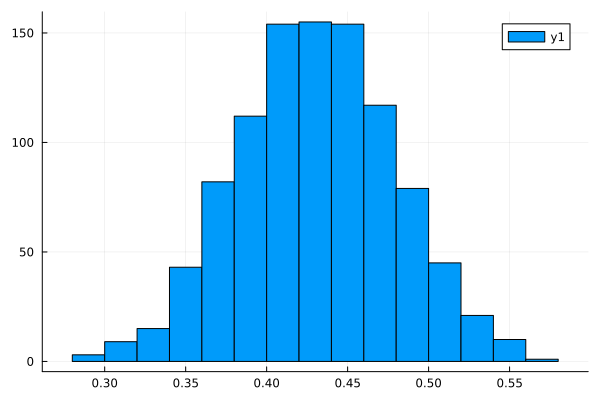

In [9]:
# Settings of the Hamiltonian Monte Carlo (HMC) sampler.
iterations = 1000
ϵ = 0.05
τ = 10

# Start sampling.
@time chain = sample(coinflip(data), HMC(ϵ, τ), iterations)
display(chain)
# Plot a summary of the sampling process for the parameter p, i.e. the probability of heads in a coin.
histogram(chain[:p])

┌ Info: Found initial step size
└   ϵ = 0.6000000000000001
Sampling: 100%|█████████████████████████████████████████| Time: 0:00:00


  0.267643 seconds (2.43 M allocations: 172.154 MiB, 23.85% gc time)


Chains MCMC chain (10000×13×1 Array{Float64, 3}):

Iterations        = 1001:1:11000
Number of chains  = 1
Samples per chain = 10000
Wall duration     = 0.22 seconds
Compute duration  = 0.22 seconds
parameters        = p
internals         = lp, n_steps, is_accept, acceptance_rate, log_density, hamiltonian_energy, hamiltonian_energy_error, max_hamiltonian_energy_error, tree_depth, numerical_error, step_size, nom_step_size

Summary Statistics
  parameters      mean       std      mcse    ess_bulk    ess_tail      rhat   ⋯
      Symbol   Float64   Float64   Float64     Float64     Float64   Float64   ⋯

           p    0.4314    0.0486    0.0007   5376.4118   6857.8386    1.0002   ⋯
                                                                1 column omitted

Quantiles
  parameters      2.5%     25.0%     50.0%     75.0%     97.5% 
      Symbol   Float64   Float64   Float64   Float64   Float64 

           p    0.3354    0.3994    0.4311    0.4641    0.5272


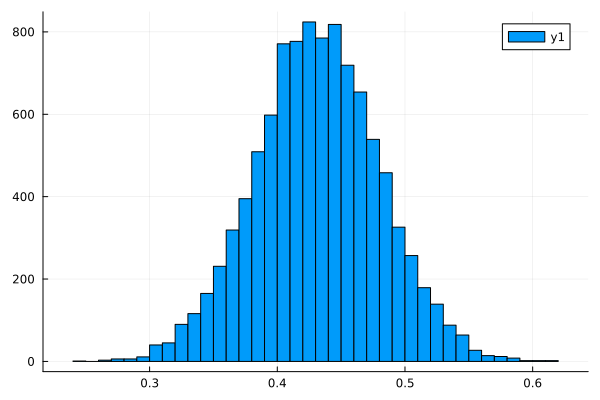

In [46]:
# Using NUTS as sampler
@time chain = sample(coinflip(data), NUTS(), iterations)
display(chain)
# Plot a summary of the sampling process for the parameter p, i.e. the probability of heads in a coin.
histogram(chain[:p])

### 3.1.1 The posterior of p is max at $ p=0.4311$. Not 0.5!
Because:
1) the data is 43% up;
2) we used a flat prior (uniform \in [0,1]). 

## 3.2 Input is 10X more data.

The number of ups is 493/1000.


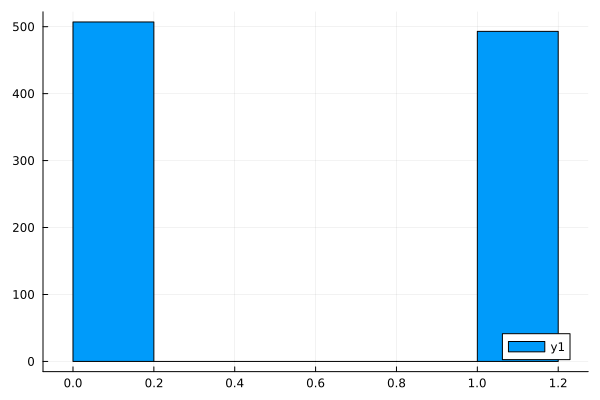

In [35]:
# Fix the seed and draw data from a Bernoulli distribution, i.e. draw heads or tails.
Random.seed!(7)
data2 = rand(Bernoulli(p_true), 1000)
println(Fmt.format(f"The number of ups is {1}/{2}.", sum(data2), length(data2)) ); 

histogram(data2)

### 3.2.1 sample using the same model but with 10X iterations

Sampling: 100%|█████████████████████████████████████████| Time: 0:00:01


  1.175580 seconds (2.50 M allocations: 140.212 MiB, 6.49% gc time)


Chains MCMC chain (10000×11×1 Array{Float64, 3}):

Iterations        = 1:1:10000
Number of chains  = 1
Samples per chain = 10000
Wall duration     = 1.12 seconds
Compute duration  = 1.12 seconds
parameters        = p
internals         = lp, n_steps, is_accept, acceptance_rate, log_density, hamiltonian_energy, hamiltonian_energy_error, numerical_error, step_size, nom_step_size

Summary Statistics
  parameters      mean       std      mcse     ess_bulk    ess_tail      rhat  ⋯
      Symbol   Float64   Float64   Float64      Float64     Float64   Float64  ⋯

           p    0.4932    0.0157    0.0001   14443.3380   9928.3113    0.9999  ⋯
                                                                1 column omitted

Quantiles
  parameters      2.5%     25.0%     50.0%     75.0%     97.5% 
      Symbol   Float64   Float64   Float64   Float64   Float64 

           p    0.4627    0.4825    0.4932    0.5039    0.5236


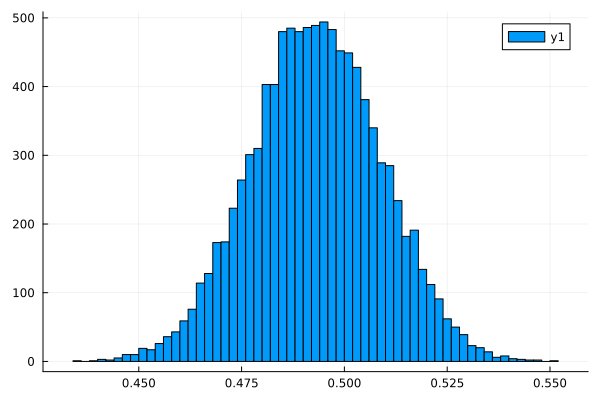

In [38]:
# sampling using the same model but with more iterations
iterations = 10000
ϵ = 0.05
τ = 10
# Start sampling.
@time chain = sample(coinflip(data2), HMC(ϵ, τ), iterations)
display(chain)
# Plot a summary of the sampling process for the parameter p, i.e. the probability of heads in a coin.
histogram(chain[:p])

### 3.2.2 same model, but using the NUTS sampler (default parameters)


┌ Info: Found initial step size
└   ϵ = 0.2
Sampling: 100%|█████████████████████████████████████████| Time: 0:00:00


  0.486774 seconds (2.44 M allocations: 172.963 MiB, 13.55% gc time)


Chains MCMC chain (10000×13×1 Array{Float64, 3}):

Iterations        = 1001:1:11000
Number of chains  = 1
Samples per chain = 10000
Wall duration     = 0.42 seconds
Compute duration  = 0.42 seconds
parameters        = p
internals         = lp, n_steps, is_accept, acceptance_rate, log_density, hamiltonian_energy, hamiltonian_energy_error, max_hamiltonian_energy_error, tree_depth, numerical_error, step_size, nom_step_size

Summary Statistics
  parameters      mean       std      mcse    ess_bulk    ess_tail      rhat   ⋯
      Symbol   Float64   Float64   Float64     Float64     Float64   Float64   ⋯

           p    0.4934    0.0158    0.0002   5357.9946   7280.9086    0.9999   ⋯
                                                                1 column omitted

Quantiles
  parameters      2.5%     25.0%     50.0%     75.0%     97.5% 
      Symbol   Float64   Float64   Float64   Float64   Float64 

           p    0.4630    0.4825    0.4933    0.5039    0.5246


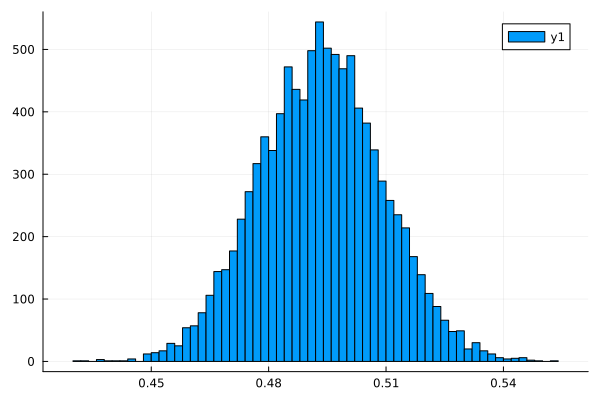

In [39]:
# Start sampling.
@time chain = sample(coinflip(data2), NUTS(), iterations)
display(chain)
# Plot a summary of the sampling process for the parameter p, i.e. the probability of heads in a coin.
histogram(chain[:p])

## 3.3 Modify the prior to alter the posterior

In [56]:
# Declare our Bayesian model，p ~ beta， x ~ Bernoilli(p)
# But let's modify the \alpha and \beta of the prior distribution.

@model function coinflip_prior_around_0_5(x)
    # Our prior belief about the probability of heads in a coin.
    p ~ Beta(100, 100)

    # The number of observations.
    N = length(x)
    for n in 1:N
        # Heads or tails of a coin are drawn from a Bernoulli distribution.
        x[n] ~ Bernoulli(p)
    end
end

coinflip_prior_around_0_5 (generic function with 2 methods)

┌ Info: Found initial step size
└   ϵ = 0.4
Sampling: 100%|█████████████████████████████████████████| Time: 0:00:00


  1.697019 seconds (3.35 M allocations: 237.140 MiB, 5.76% gc time, 83.75% compilation time: 81% of which was recompilation)


Chains MCMC chain (10000×13×1 Array{Float64, 3}):

Iterations        = 1001:1:11000
Number of chains  = 1
Samples per chain = 10000
Wall duration     = 1.03 seconds
Compute duration  = 1.03 seconds
parameters        = p
internals         = lp, n_steps, is_accept, acceptance_rate, log_density, hamiltonian_energy, hamiltonian_energy_error, max_hamiltonian_energy_error, tree_depth, numerical_error, step_size, nom_step_size

Summary Statistics
  parameters      mean       std      mcse    ess_bulk    ess_tail      rhat   ⋯
      Symbol   Float64   Float64   Float64     Float64     Float64   Float64   ⋯

           p    0.4768    0.0284    0.0004   4652.8732   6780.5463    1.0001   ⋯
                                                                1 column omitted

Quantiles
  parameters      2.5%     25.0%     50.0%     75.0%     97.5% 
      Symbol   Float64   Float64   Float64   Float64   Float64 

           p    0.4219    0.4575    0.4767    0.4963    0.5323


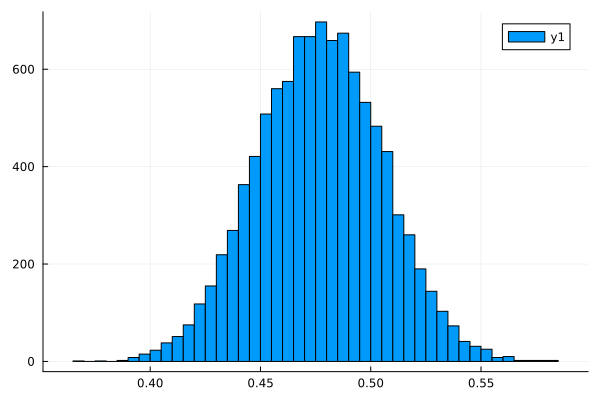

In [55]:
# Start sampling.
@time chain = sample(coinflip_prior_around_0_5(data), NUTS(), iterations)
display(chain)
# Plot a summary of the sampling process for the parameter p, i.e. the probability of heads in a coin.
histogram(chain[:p])